In [1]:
# ! unzip data\ \(2\).zip

In [2]:
! module load Anaconda3/2020.07 # load the conda module

In [3]:
! pip install natsort > /dev/null

In [4]:
!pip install memoization > /dev/null

In [1]:
import datetime
import glob
import random
from functools import lru_cache

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.utils import to_categorical
from memoization import cached
from natsort import natsorted
from scipy import stats
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# from keras_flops import get_flops
# max_flops = 1e7
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling1D,
    MaxPooling1D,
)
from tensorflow.keras.models import Sequential

2025-11-19 20:33:53.859108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-19 20:33:53.859178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-19 20:33:53.860632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-19 20:33:53.868908: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 20:33:55.379361: W tensorflow/compiler/tf2

In [2]:
@keras.saving.register_keras_serializable("ConditionalPoolingLayer1D")
class ConditionalPoolingLayer1D(keras.layers.Layer):
    def __init__(self, pool_size, pool_type, **kwargs):
        super(ConditionalPoolingLayer1D, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.pool_type = pool_type
        if pool_type == "max":
            self.pooling_layer = layers.MaxPooling1D(pool_size=pool_size)
        elif pool_type == "average":
            self.pooling_layer = layers.AveragePooling1D(pool_size=pool_size)

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        output_length = input_shape[1] // self.pool_size

        if output_length > 0:
            return self.pooling_layer(inputs)
        else:
            return inputs

    def get_config(self):
        base_config = super().get_config()
        config = {
            "pool_size": keras.saving.serialize_keras_object(self.pool_size),
            "pool_type": keras.saving.serialize_keras_object(self.pool_type),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        pool_size_config = config.pop("pool_size")
        pool_type_config = config.pop("pool_type")
        pool_size = keras.saving.deserialize_keras_object(pool_size_config)
        pool_type = keras.saving.deserialize_keras_object(pool_type_config)
        return cls(pool_size, pool_type, **config)

In [3]:
def IMUModel(Choromosome, input_shape, output_shape):
    # try:
    time_domain = keras.Sequential()
    time_domain.add(keras.Input(shape=input_shape, name="input_time"))
    time_domain.add(layers.BatchNormalization())

    Activations = ["", "relu", "tanh", "sigmoid"]
    Padding = ["", "valid", "same"]
    for Block in range(10):
        if Choromosome[0 + 9 * Block]:
            time_domain.add(
                layers.Conv1D(
                    int(Choromosome[1 + 9 * Block]),
                    kernel_size=(int(Choromosome[2 + 9 * Block]),),
                    activation=Activations[int(Choromosome[3 + 9 * Block])],
                    padding=Padding[int(Choromosome[4 + 9 * Block])],
                    strides=(int(Choromosome[5 + 9 * Block]),),
                )
            )
            if Choromosome[6 + 9 * Block]:
                time_domain.add(layers.BatchNormalization())
            if Choromosome[7 + 9 * Block]:
                if Choromosome[8 + 9 * Block]:
                    time_domain.add(ConditionalPoolingLayer1D(2, pool_type="max"))
                else:
                    time_domain.add(ConditionalPoolingLayer1D(2, pool_type="average"))

    if Choromosome[90]:
        time_domain.add(layers.GlobalAveragePooling1D())
    if Choromosome[91]:
        time_domain.add(layers.Dropout(Choromosome[92]))
    time_domain.add(layers.Flatten(name="flatten"))

    for Block in range(3):
        if Choromosome[93 + Block * 7]:
            if Choromosome[94 + Block * 7]:
                time_domain.add(layers.BatchNormalization())
            if Choromosome[95 + Block * 7]:
                time_domain.add(
                    layers.Dense(
                        Choromosome[96 + Block * 7],
                        activation=Activations[int(Choromosome[97 + Block * 7])],
                    )
                )
            if Choromosome[98 + Block * 7]:
                time_domain.add(layers.Dropout(Choromosome[99 + Block * 7]))
    time_domain.add(
        layers.Dense(
            output_shape,
            activation="softmax",
            kernel_regularizer=keras.regularizers.l1(Choromosome[114]),
        )
    )
    learning_rate = Choromosome[115]
    time_domain.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc", curve="PR"),
            # tf.keras.metrics.F1Score(name="f1_score"),
        ],
    )
    return time_domain


# except:
#     return None

In [4]:
def get_window(X, y, window_size=20, jump_size=10):
    X_window = []
    y_window = []
    for r in range(0, len(X) - window_size, jump_size):
        x = X[r : r + window_size]
        y = Y[r : r + window_size]
        X_window.append(x)
        y_window.append(stats.mode(y)[0])
    X_window = np.array(X_window)
    y_window = np.array(y_window)

    indices = np.arange(X_window.shape[0])
    # np.random.shuffle(indices)
    return X_window[indices], y_window[indices]

In [5]:
def train(cnn, X_train, y_train, X_test, y_test, X_valid, y_valid, BATCH_SIZE):
    # return random.random()
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)
    y_test = to_categorical(y_test)
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    history = cnn.fit(
        X_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[callback],
        # class_weight=class_weights,
        validation_data=(X_valid, y_valid),
        verbose=FITVERBOSE,
    )

    y_pred = cnn(X_valid).numpy().argmax(axis=1)

    print(
        classification_report(y_valid.argmax(axis=1), y_pred, digits=4),
        file=open("log.txt", "a"),
    )
    print(confusion_matrix(y_valid.argmax(axis=1), y_pred), file=open("log.txt", "a"))
    print(
        (
            confusion_matrix(y_valid.argmax(axis=1), y_pred, normalize="true") * 100
        ).round(2),
        file=open("log.txt", "a"),
    )

    return f1_score(y_valid.argmax(axis=1), y_pred, average="macro")

In [6]:
@cached(max_size=300)
def fitness_function(chromosome):
    assert len(chromosome) == len_data+len_hp+1, 'len is %d but must be %d' % (len(chromosome), len_data+len_hp+1)
    # global n_diff
    # window_sizes = [20, 40, 80, 120, 150]
    # WINDOW_SIZE = window_sizes[int(chromosome[-3])]
    # jump_sizes = [int(0.5 * window_size), int(0.25 * window_size), int(0.10 * window_size)]
    # JUMP_SIZE = jump_sizes[int(chromosome[-2])]
    
    batch_sizes = [64, 128, 256, 512, 1024]
    BATCH_SIZE = chromosome[-1]
    
    try:
        model = IMUModel(
            chromosome[len_data : len_data + len_hp],
            input_shape=(WINDOW_SIZE, 6),
            output_shape=len(classes),
        )
        print("Bad", chromosome, file=open("log.txt", "a"))
    except:
        return 0
    
    indices_to_remove = list(chromosome[:len_data])
    X_train_undersampled = np.delete(X_train, indices_to_remove, axis=0)
    y_train_undersampled = np.delete(y_train, indices_to_remove, axis=0)
    print("*****" * 10, file=open("log.txt", "a"))
    print(datetime.datetime.now(), file=open("log.txt", "a"))
    print(chromosome, file=open("log.txt", "a"))
    t = 0
    for _ in range(N_TRIALS):
        print("%%%" * 10, file=open("log.txt", "a"))
        t += train(
            model,
            X_train_undersampled,
            y_train_undersampled,
            X_test,
            y_test,
            X_valid,
            y_valid,
            BATCH_SIZE = BATCH_SIZE
        )
        print("^^^" * 10, file=open("log.txt", "a"))
    print("#####" * 10, file=open("log.txt", "a"))
    return t / N_TRIALS

In [7]:
# parent selection function
# tournament technique
def parent_selection():
    # Initialize the best candidate as None
    best_candidate = None

    # Sample a subset of the population
    for _ in range(PopulationSize // 5):
        ch = random.choice(Population)
        # Update best_candidate if it is None or the current chromosome has a lower cost
        if best_candidate is None or ch[-1] > best_candidate[-1]:
            best_candidate = ch

    # Return the chromosome portion without the cost if needed
    return best_candidate[:-1]


# class-preserving crossover
def crossover_data(parent1, parent2):
    # Initialize offspring as copies of parents
    offspring1, offspring2 = list(parent1), list(parent2)
    start = 0

    # Perform crossover on each class segment
    for cls, diff in n_diff.items():
        end = start + diff  # End index for this class segment

        # Extract class segments
        segment1 = offspring1[start:end]
        segment2 = offspring2[start:end]

        # Select crossover points within the segment
        crossover_point = np.random.randint(
            1, diff
        )  # Single crossover point for simplicity

        # Swap segments at the crossover point
        new_segment1 = segment1[:crossover_point] + [
            x for x in segment2 if x not in segment1[:crossover_point]
        ]
        new_segment2 = segment2[:crossover_point] + [
            x for x in segment1 if x not in segment2[:crossover_point]
        ]
        if len(new_segment1) < diff:
            unused_genes = list(set(class_indices[cls]) - set(new_segment1))
            new_segment1 += np.random.choice(
                unused_genes, size=diff - len(new_segment1), replace=False
            ).tolist()
        elif len(new_segment1) > diff:
            new_segment1 = np.random.choice(
                new_segment1, size=diff, replace=False
            ).tolist()

        if len(new_segment2) < diff:
            unused_genes = list(set(class_indices[cls]) - set(new_segment2))
            new_segment2 += np.random.choice(
                unused_genes, size=diff - len(new_segment2), replace=False
            ).tolist()
        elif len(new_segment2) > diff:
            new_segment2 = np.random.choice(
                new_segment2, size=diff, replace=False
            ).tolist()

        # Assign the new segments back to offspring
        offspring1[start:end] = new_segment1
        offspring2[start:end] = new_segment2

        # Move to the next class segment
        start = end
    # offspring1.append(fitness_function(offspring1))
    # offspring2.append(fitness_function(offspring2))
    assert len(offspring1) == len(parent1)
    assert len(offspring2) == len(parent1)
    return [offspring1, offspring2]


# mutation function
# single swap technique
def mutation_data(chromosome):
    p, q = random.sample(range(len(chromosome)), 2)
    chromosome[p], chromosome[q] = chromosome[q], chromosome[p]
    return chromosome

def generate_hp_chromosome():
    # len(vartype), len(varbound)
    individual = []
    for i in range(len(vartype)):
        if vartype[i] == "int":
            # Generate a random integer within the specified bounds
            value = random.randint(varbound[i][0], varbound[i][1])
        elif vartype[i] == "real":
            # Generate a random float within the specified bounds
            value = random.uniform(varbound[i][0], varbound[i][1])
        individual.append(value)
    return individual

def crossover_hp(parent1, parent2):
    """Perform one-point crossover between two parents."""
    crossover_point = random.randint(
        1, len(parent1) - 1
    )  # Ensure at least one gene is swapped
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return [child1, child2]


def mutation_hp(individual):
    """Mutate a single randomly selected gene in an individual with a given mutation rate, respecting variable bounds."""
    # Randomly decide if mutation occurs
    index_to_mutate = random.randint(0, len(individual) - 1)

    if vartype[index_to_mutate] == "int":
        # Randomly change the integer within its bounds
        individual[index_to_mutate] = random.randint(
            varbound[index_to_mutate][0], varbound[index_to_mutate][1]
        )
    elif vartype[index_to_mutate] == "real":
        # Randomly change the real number within a small range
        mutation_amount = random.uniform(-0.1, 0.1)  # Adjust this range as needed
        new_value = individual[index_to_mutate] + mutation_amount

        # Ensure the new value is within bounds
        new_value = max(
            varbound[index_to_mutate][0], min(new_value, varbound[index_to_mutate][1])
        )
        individual[index_to_mutate] = new_value
    return individual

def mutation(ch):
    assert len(ch) == len_data+len_hp+1+1, 'len is %d but must be %d' % (len(ch), len_data+len_hp+1+1)
    ch[:len_data] = mutation_data(ch[:len_data])
    ch[len_data : len_data + len_hp] = mutation_hp(ch[len_data : len_data + len_hp])
    ch[-1] = fitness_function(ch[:-1])


def crossover(p1, p2):
    # Perform crossover on the data part of the chromosomes
    c1_data, c2_data = crossover_data(p1[:len_data], p2[:len_data])

    # Perform crossover on the hyperparameter part of the chromosomes
    c1_hp, c2_hp = crossover_hp(
        p1[len_data : len_data + len_hp], p2[len_data : len_data + len_hp]
    )

    # Combine both parts to form the new chromosomes
    c1 = c1_data + c1_hp + [p2[-1]]
    c2 = c2_data + c2_hp + [p1[-1]]

    # Compute fitness for the whole chromosome
    c1_fitness = fitness_function(c1)
    c2_fitness = fitness_function(c2)

    # Append fitness scores to the chromosomes
    c1.append(c1_fitness)
    c2.append(c2_fitness)

    return [c1, c2]

In [8]:
N_TRIALS = 1
EPOCHS = 2
PopulationSize = 10
GENERATIONS = 2
max_children = PopulationSize // 3  # Maximum number of children
crossoverProbability = 0.8  # Probability of crossover
mutationProbability = 0.2  # Probability of mutation
WINDOW_SIZE = 24
JUMP_SIZE  = WINDOW_SIZE//2
FITVERBOSE = 0

In [9]:
vartype = (
    ["int", "int", "int", "int", "int", "int", "int", "int", "int"] * 10
    + ["int", "int", "real"]
    + ["int", "int", "int", "int", "int", "int", "real"] * 3
    + ["real", "real"]
)
varbound = (
    [[0, 1], [1, 500], [1, 8], [1, 3], [1, 2], [1, 2], [0, 1], [0, 1], [0, 1]] * 10
    + [[0, 1], [0, 1], [0.4, 0.5]]
    + [[0, 1], [0, 1], [0, 1], [3, 1024], [1, 3], [0, 1], [0.4, 0.5]] * 3
    + [[1e-5, 1e-3], [1e-6, 1e-2]]
)

In [10]:
classes = ["standing", "bending2", "cycling", "lying", "sitting", "walking", "bending1"]

X = []
Y = []
for i, folder in enumerate(classes):
    files = natsorted(glob.glob("./data/%s/*.csv" % (folder), recursive=True))
    df = pd.concat(map(lambda file: pd.read_csv(file, skiprows=4), files))
    x = df.values[:, 1:]

    y = np.array([i] * len(x))
    wx, wy = get_window(x, y, window_size=WINDOW_SIZE, jump_size=JUMP_SIZE)
    # print("class", folder, wx.shape)
    X.extend(wx)
    Y.extend([i] * len(wx))
X = np.array(X)
y = np.array(Y)
# X.shape, y.shape

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

# X_train, y_train = balance(X_train, y_train)

# labels = y_train.flatten()
# labels_unique = np.unique(labels)
# class_weights = compute_class_weight("balanced", classes=labels_unique, y=labels)
# class_weights = dict(zip(labels_unique, class_weights))
# print(class_weights)

# Get unique classes and their counts
classes, counts = np.unique(y_train, return_counts=True)

# Determine the minority class size
n_minority = np.min(counts)
n_diff = {
    cls: count - n_minority for cls, count in zip(classes, counts) if count > n_minority
}

# Collect indices for each class
class_indices = {cls: np.where(y_train == cls)[0] for cls in classes}
# class_indices
# Shuffle indices within each class
for cls in class_indices:
    np.random.shuffle(class_indices[cls])

len_data = sum(n_diff.values())
len_hp = len(generate_hp_chromosome())
# len_hp
# len_data + len_hp

# X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_test.shape, y_valid.shape

/tmp/ipykernel_2733706/507675964.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  y_window.append(stats.mode(y)[0])
/tmp/ipykernel_2733706/507675964.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  y_window.append(stats.mode(y)[0])
/tmp/ipykernel_2733706/507675964.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  y_window.append(stats.mode(y)[0])
/tmp/ipykernel_2733706/507675964.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  y_window.append(stats.mode(y)[0])
/tmp/ipykernel_2733706/507675964.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values wi

In [11]:
# initialization
Population = []

# Step 1: Ensure each index is covered at least once by creating chromosomes from fixed-size chunks
for cls, diff in n_diff.items():
    indices = class_indices[cls]
    for i in range(0, len(indices), diff):
        chromosome = []
        # Collect exactly `n_diff[cls]` indices from each class
        for cls_inner, diff_inner in n_diff.items():
            inner_indices = class_indices[cls_inner]
            # Slice the indices to get exactly `diff_inner` elements, with padding if necessary
            chunk = inner_indices[i : i + diff_inner].tolist()
            if len(chunk) < diff_inner:
                chunk += inner_indices[: diff_inner - len(chunk)].tolist()
            chromosome.extend(chunk)

        Population.append(tuple(chromosome))

Population = set(Population)
Population = list(map(list, Population))
# Step 2: Add additional random unique chromosomes to reach PopulationSize
while len(Population) < PopulationSize:
    chromosome = []
    for cls, diff in n_diff.items():
        # Randomly select `diff` indices from each majority class
        random_indices = np.random.choice(
            class_indices[cls], size=diff, replace=False
        ).tolist()
        chromosome.extend(random_indices)

    # Add the chromosome only if it’s unique
    if chromosome not in Population:
        Population.append(chromosome)

for i in range(len(Population)):
    added = False
    while not added:
        try:
            hpc = generate_hp_chromosome()
            IMUModel(hpc, input_shape=(WINDOW_SIZE,6), output_shape=len(classes))
            Population[i].extend(hpc)
            added = True
        except:
            pass
    Population[i].append(random.randint(0, 3)) # BATCH_SIZE
    # Population[i].append(0) #cost

print(np.array(Population).shape)

for i in range(len(Population)):
    Population[i].append(fitness_function(Population[i]))

assert len(Population) == PopulationSize
print(np.array(Population).shape)

(10, 1598)


/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.loca

(10, 1599)


/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
cost_list = list()
Population.sort(key=lambda q: q[-1], reverse=True)
cost_list.append(list(map(lambda p: p[-1], Population)))
iteration_count = 0
best_cost = Population[0][-1]
patience = 10  # Number of generations to wait for improvement
patience_counter = 0  # Counter for generations without improvement

print("%dth iteration, current fitness: %.2f" % (iteration_count, best_cost * 100))

for generation in range(1, GENERATIONS + 1):
    np.array(Population).shape
    random.shuffle(Population)
    # recombine parents
    new_children = list()
    for _ in range(max_children):
        p1, p2 = parent_selection(), parent_selection()
        done = False
        if random.random() < crossoverProbability:
            children = crossover(p1, p2)
            done = True
        else:
            children = [p1[:]+[0], p2[:]+[0]]
        for child in children:
            if random.random() < mutationProbability or not done:
                mutation(child)
            new_children.append(child)
    Population.extend(new_children)

    # kill people with upper cost (goal: minimizing cost)
    Population.sort(key=lambda q: q[-1], reverse=True)
    del Population[PopulationSize:]

    cost_list.append(list(map(lambda p: p[-1], Population)))
    iteration_count += 1
    current_best_cost = Population[0][-1]

    # Check for improvement
    if current_best_cost < best_cost:
        best_cost = current_best_cost
        patience_counter = 0  # Reset counter if there's an improvement
    else:
        patience_counter += 1  # Increment counter if no improvement

    if patience_counter >= patience:
        print("Early stopping at generation %d, no improvement in last %d generations." % (generation, patience))
        break

    if iteration_count % 1 == 0:
        print(
            "%03dth iteration, current fitness: %.2f"
            % (iteration_count, 100 * best_cost)
        )

0th iteration, current fitness: 56.09


/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.loca

001th iteration, current fitness: 56.09


/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.loca

002th iteration, current fitness: 56.09


/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/v54v562/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
print("FINAL", file=open("log.txt", "a"))
print(
    [
        WINDOW_SIZE,
        N_TRIALS,
        EPOCHS,
        PopulationSize,
        GENERATIONS,
        max_children,
        crossoverProbability,
        mutationProbability,
    ],
    file=open("log.txt", "a"),
)
print(Population, file=open("log.txt", "a"))
print("cost", cost_list, file=open("log.txt", "a"))

2th iteration, current cost: 68.41


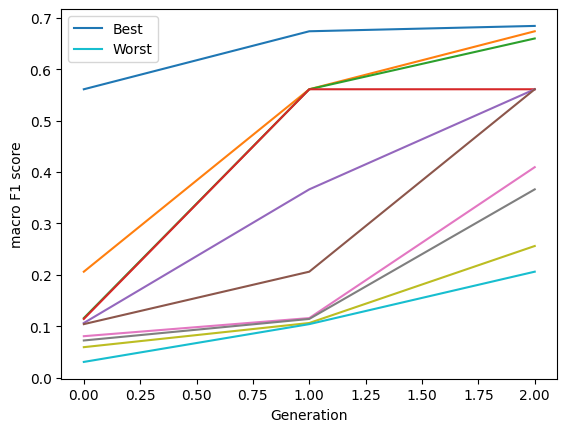

In [14]:
print("%dth iteration, current cost: %.2f" % (iteration_count, 100 * Population[0][-1]))
iteration = range(len(cost_list))
plt.plot(
    iteration,
    cost_list,
    label=["Best"] + ["" for i in range(1, PopulationSize - 1)] + ["Worst"],
)
plt.xlabel("Generation")
plt.ylabel("macro F1 score")
plt.legend()

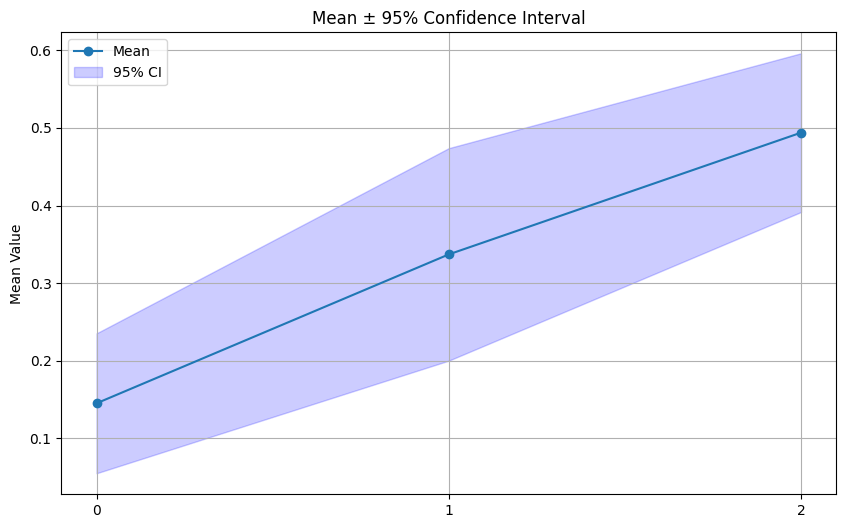

In [15]:
# Calculate the mean along the second dimension (dim 12)
mean = np.mean(cost_list, axis=1)

# Calculate the standard error of the mean
sem = np.std(cost_list, axis=1) / np.sqrt(np.array(cost_list).shape[1])

# Calculate the 95% confidence interval
ci = 1.96 * sem  # 1.96 is the z-score for 95% CI

# Create the upper and lower bounds of the CI
upper_bound = mean + ci
lower_bound = mean - ci

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mean, label="Mean", marker="o")
plt.fill_between(
    range(len(mean)), lower_bound, upper_bound, color="b", alpha=0.2, label="95% CI"
)
plt.title("Mean ± 95% Confidence Interval")
plt.ylabel("Mean Value")
plt.xticks(range(len(mean)))
plt.legend()
plt.grid()
plt.show()